In [1]:
import os
os.chdir("..")

In [2]:
from implicit_filter import CuPyFilter
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import xarray as xr

# Get FESOM mesh and data

### Data on Levante

In [3]:
mesh = xr.open_dataset("/work/ab0995/a270088/sisters/runs/NG5/fesom.mesh.diag.nc") # 7M mesh
data_u = xr.open_dataset("/work/bk1341/a270029/rundir_tco1279_1990/tco1279l137/i1bw/hres/cray.craympich/lum.intel.sp/restart_tco1279_multio_1991/fesom.1991.oce.restart/u.nc")
data_v = xr.open_dataset("/work/bk1341/a270029/rundir_tco1279_1990/tco1279l137/i1bw/hres/cray.craympich/lum.intel.sp/restart_tco1279_multio_1991/fesom.1991.oce.restart/v.nc")

dxm = 5 # Approximate resolution of the mesh in km

### Data on Jewels

In [ ]:
mesh = xr.open_dataset("/p/project/chhb19/mueller29/meshes/AO_40/fesom.mesh.diag.nc")
data_u = xr.open_dataset("/p/scratch/chhb19/mueller29/AO_40_nopc/2014/u.fesom.2014.nc")
data_v = xr.open_dataset("/p/scratch/chhb19/mueller29/AO_40_nopc/2014/v.fesom.2014.nc")

dxm = 1 # Approximate resolution of the mesh in km

### Read data

In [4]:
u = data_u['u'].values[0, 0, :]
v = data_v['v'].values[0, 0, :]

# Filtering

### Define wavelengths

In [5]:
Kc = np.array([2, 2.2, 2.5, 3, 4, 5, 6, 8, 10, 12, 16, 20, 24, 30, 40, 60, 80, 100, 200]) * dxm
Kc = 2 * math.pi / Kc  # Wavenumbers
nr = len(Kc)
cyclic_length = 360  # in degrees; if not cyclic, take it larger than  zonal size
cyclic_length = cyclic_length * math.pi / 180 

### Prepare filter manually

It's a large mesh so it can take a few minutes

In [26]:
jf = CuPyFilter()
xcoord = mesh['lon'].values
ycoord = mesh['lat'].values
tri = mesh['elements'].values.T - 1
n2d = len(xcoord)
e2d = len(tri[:, 1])
jf.prepare(n2d, e2d, tri, xcoord, ycoord, meshtype='r', carthesian=False, cyclic_length=cyclic_length)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


### or let it load data from mesh file

In [7]:
jf = CuPyFilter()
jf.prepare_from_file("/work/ab0995/a270088/sisters/runs/NG5/fesom.mesh.diag.nc", meshtype='r', carthesian=False, cyclic_length=cyclic_length)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


It is advised to save auxiliary arrays as files. They only need to be computed once for each mesh.

In [ ]:
jf.save_to_file("filter_cash")

### or load cashed auxiliary arrays

In [6]:
jf = CuPyFilter.load_from_file("filter_cash.npz")

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [14]:
type(u)

numpy.ndarray

In [8]:
type(jf._full)

bool

### Filter

#### Single case

In [10]:
%%time
ttsu, ttsv = jf.compute_velocity(1, Kc[-1], u, v)

CPU times: user 5.18 s, sys: 794 ms, total: 5.98 s
Wall time: 2.71 s


#### Before

In [11]:
xcoord = mesh['lon'].values
ycoord = mesh['lat'].values
tri = mesh['elements'].values.T - 1

ok =(xcoord[tri].max(axis=1)-xcoord[tri].min(axis=1))<10 
plt.rcParams['figure.figsize'] = [12, 6]
triang = mpl.tri.Triangulation(xcoord, ycoord, tri[ok, :])

(35.0, 37.0)

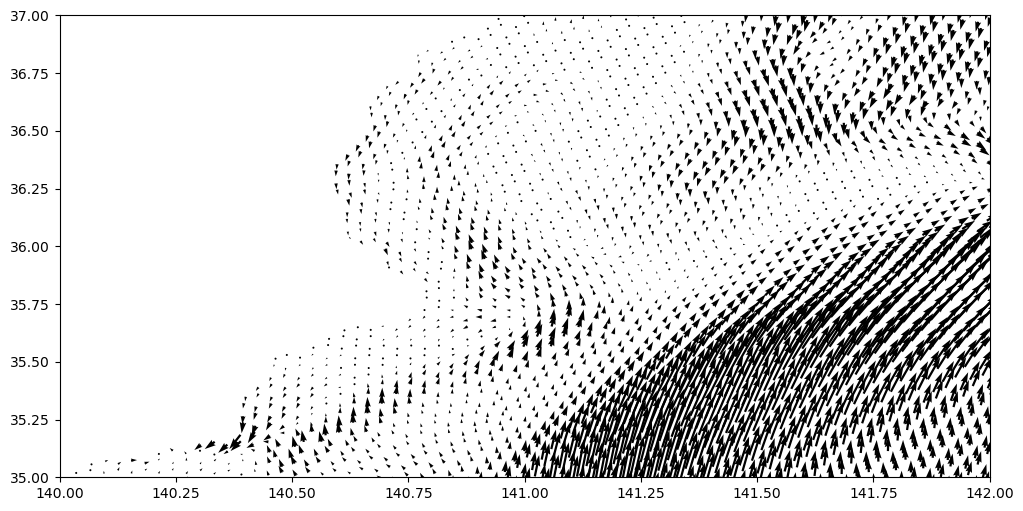

In [25]:
plt.quiver(np.mean(xcoord[tri], axis=1), np.mean(ycoord[tri], axis=1), u, v, scale_units='inches', scale=4)
plt.xlim([140, 142])
plt.ylim([35, 37])

#### After

(35.0, 37.0)

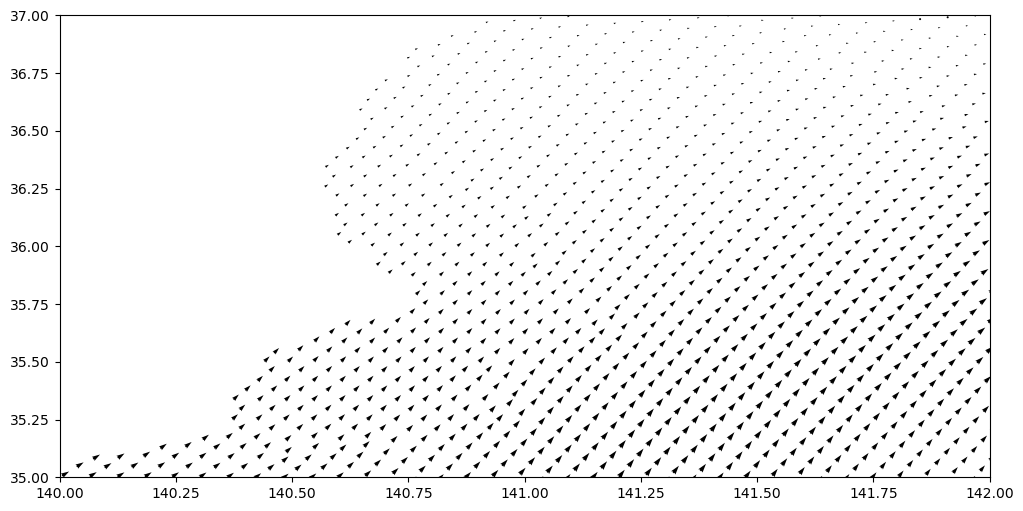

In [26]:
plt.quiver(xcoord, ycoord, ttsu, ttsv, scale_units='inches', scale=4)
plt.xlim([140, 142])
plt.ylim([35, 37])

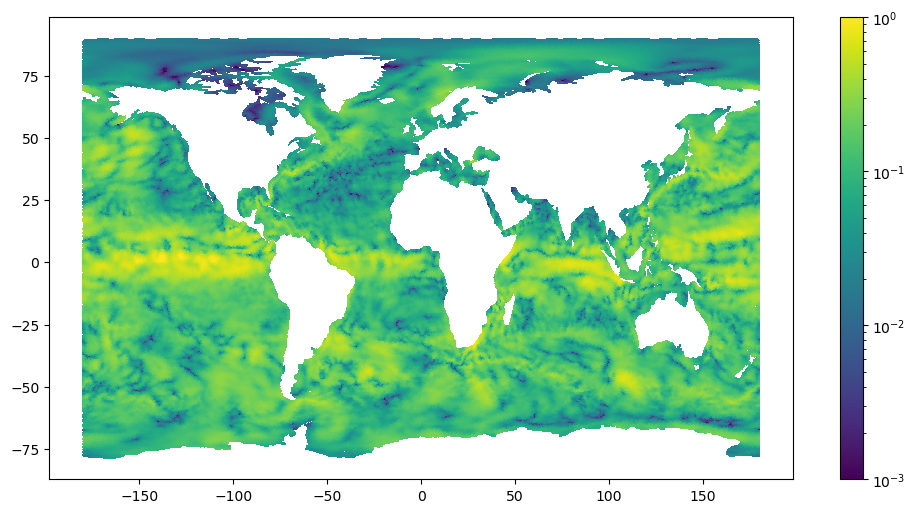

In [28]:
plt.tripcolor(triang, np.sqrt(np.square(ttsu) + np.square(ttsv)), norm=mpl.colors.LogNorm(vmin=1e-3,vmax=1e-0))
plt.colorbar()